# SAM3 Interactive Visual Exemplar

**Cell 1**: Load model (run once)  
**Cell 2**: Draw boxes & run inference (run multiple times)

In [1]:
# Cell 1: Load Model (run once)
import sys
sys.path.append(r"D:\SAM")

import cv2
import torch
from PIL import Image
from pathlib import Path
from transformers import Sam3Model, Sam3Processor
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RESOLUTION = 1008

print(f"Device: {DEVICE}")
print("Loading SAM3 model...")

model = Sam3Model.from_pretrained("facebook/sam3").to(DEVICE, dtype=torch.bfloat16)
model.eval()

processor = Sam3Processor.from_pretrained("facebook/sam3")
processor.image_processor.size = {"height": RESOLUTION, "width": RESOLUTION}

print("Model loaded!")

Device: cuda
Loading SAM3 model...


Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

Model loaded!


Controls: Drag=draw, ENTER=confirm & draw more, ESC=done
  Box 1: [346, 312, 428, 394]

Selected 1 exemplar box(es)
Found 54 similar objects!


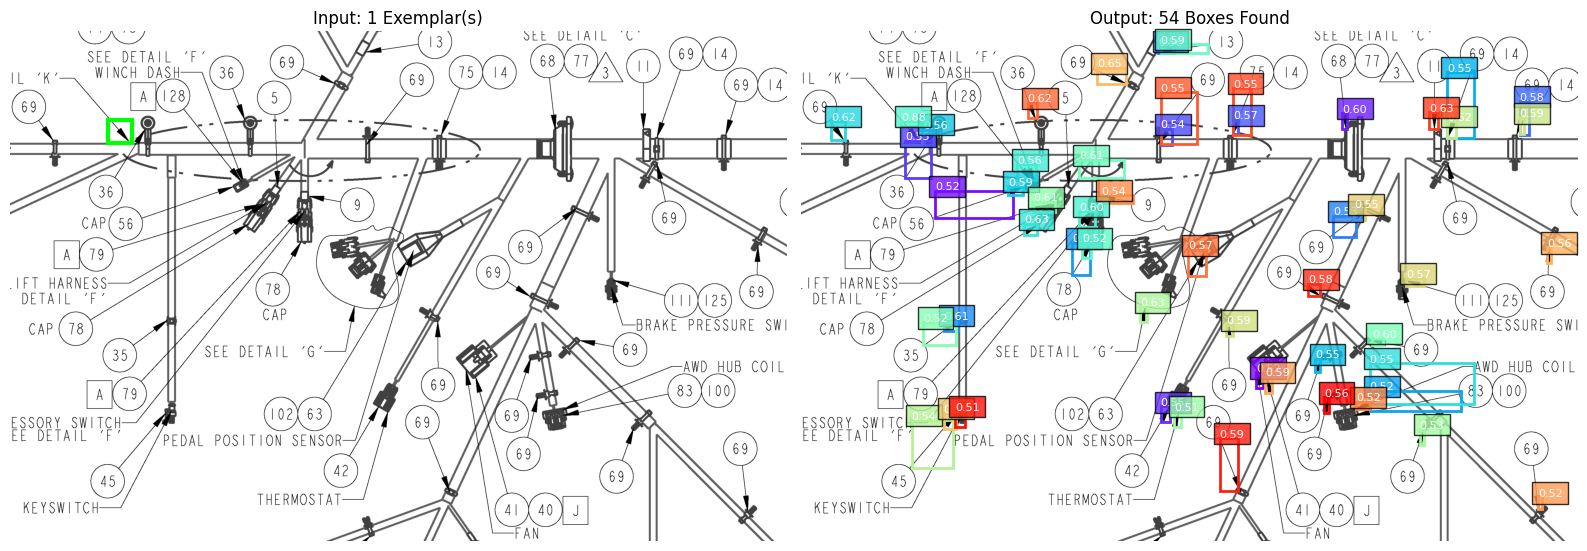

In [4]:
# Cell 2: Draw boxes & Run Inference (change IMAGE_PATH and re-run)

# === CONFIG ===
IMAGE_PATH = r"C:\Users\krish\Downloads\Pages from 2417921_02FEB24 1-1_slice2.png"
THRESHOLD = 0.5

# === DRAW BOXES ===
img = cv2.imread(IMAGE_PATH)
h, w = img.shape[:2]
scale = min(1.0, 1200 / max(h, w))
display_img = cv2.resize(img, None, fx=scale, fy=scale) if scale < 1 else img.copy()

boxes = []
print("Controls: Drag=draw, ENTER=confirm & draw more, ESC=done")

while True:
    display_copy = display_img.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = [int(c * scale) for c in box]
        cv2.rectangle(display_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    roi = cv2.selectROI(f"Draw Box ({len(boxes)} selected)", display_copy, False, True)
    cv2.destroyAllWindows()
    
    if roi[2] == 0 or roi[3] == 0:
        break
    
    x1, y1 = int(roi[0]/scale), int(roi[1]/scale)
    x2, y2 = int((roi[0]+roi[2])/scale), int((roi[1]+roi[3])/scale)
    boxes.append([x1, y1, x2, y2])
    print(f"  Box {len(boxes)}: [{x1}, {y1}, {x2}, {y2}]")

print(f"\nSelected {len(boxes)} exemplar box(es)")

if boxes:
    # === RUN INFERENCE ===
    image = Image.open(IMAGE_PATH).convert("RGB")
    
    inputs = processor(
        images=image,
        input_boxes=[boxes],
        input_boxes_labels=[[1] * len(boxes)],
        return_tensors="pt"
    )
    original_sizes = inputs.get("original_sizes").tolist()
    inputs = {k: v.to(DEVICE, dtype=torch.bfloat16) if v.dtype == torch.float32 else v.to(DEVICE)
              for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    results = processor.post_process_instance_segmentation(
        outputs, threshold=THRESHOLD, mask_threshold=0.5, target_sizes=original_sizes
    )[0]
    
    detected_boxes = results['boxes']
    scores = results['scores']
    print(f"Found {len(detected_boxes)} similar objects!")
    
    # === SHOW RESULTS (boxes only) ===
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Left: exemplars
    axes[0].imshow(image)
    for i, box in enumerate(boxes):
        rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                  linewidth=3, edgecolor='lime', facecolor='none')
        axes[0].add_patch(rect)
    axes[0].set_title(f"Input: {len(boxes)} Exemplar(s)")
    axes[0].axis('off')
    
    # Right: detected boxes
    axes[1].imshow(image)
    n = max(len(detected_boxes), 1)
    cmap = matplotlib.colormaps.get_cmap("rainbow").resampled(n)
    for i, (box, score) in enumerate(zip(detected_boxes, scores)):
        bx = box.float().cpu().numpy()
        rect = patches.Rectangle((bx[0], bx[1]), bx[2]-bx[0], bx[3]-bx[1],
                                  linewidth=2, edgecolor=cmap(i), facecolor='none')
        axes[1].add_patch(rect)
        axes[1].text(bx[0], bx[1]-5, f"{score.item():.2f}", color='white', fontsize=8,
                    bbox=dict(facecolor=cmap(i), alpha=0.8))
    axes[1].set_title(f"Output: {len(detected_boxes)} Boxes Found")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()